#**Task 2 of Mini Project: Text Classification using Deep Learning**

##**1. Data Loading**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
data = pd.read_csv('/content/dataset  - dataset 850.csv')
data.head()

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  848 non-null    object
 1   Category    848 non-null    object
dtypes: object(2)
memory usage: 13.4+ KB
None

Sample data:
                       Unnamed: 0    Category
0  Data Structures and Algorithms   Technical
1  Leadership and Team Management    Business
2       3D Animation with Blender    Creative
3   Psychology and Human Behavior  Humanities
4      Web Development with React   Technical


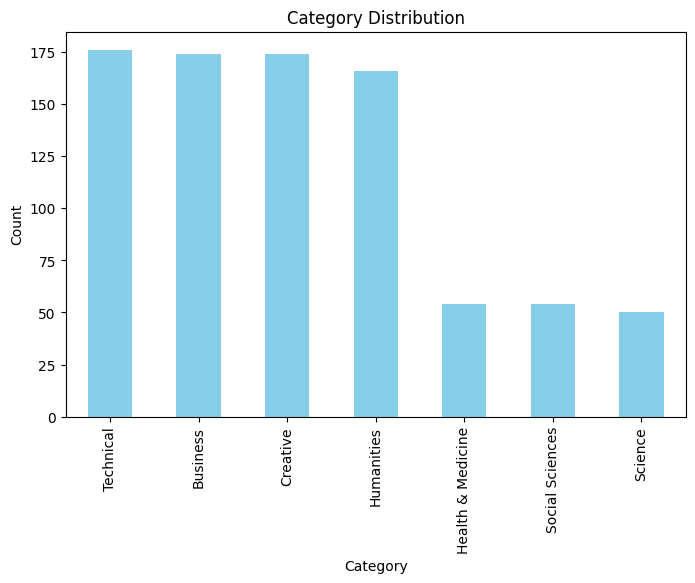

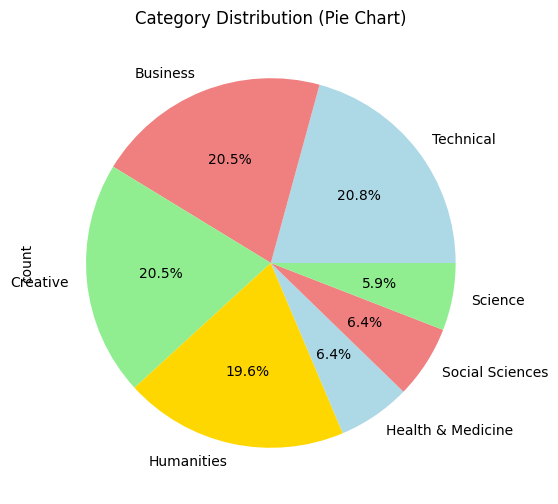

Count of unknown labels: 0


In [ ]:
print("Dataset overview:")
print(data.info())
print("\nSample data:")
print(data.head())

plt.figure(figsize=(8, 5))
data['Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

print("\n")

plt.figure(figsize=(6, 6))
data['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Category Distribution (Pie Chart)')
# plt.ylabel('')  # Hide y-label for better visualization
plt.show()

unknown_count = (data['Category'] == 'unknown').sum()
print(f"Count of unknown labels: {unknown_count}")

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

##**2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

train_data['processed_text'] = train_data['Unnamed: 0'].apply(preprocess_text)
val_data['processed_text'] = val_data['Unnamed: 0'].apply(preprocess_text)
test_data['processed_text'] = test_data['Unnamed: 0'].apply(preprocess_text)

train_data[[ 'processed_text']].head()

,processed_text
205,market research data analytics
478,world history civilization
398,photography beginners
632,ux ui design principles
552,python beginners


##**3. Text Embedding**

In [ ]:
# pip install gensim

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()


tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")
print(X_train_bow)
print(X_train_tfidf)
# print(X_train_fasttext)

Embedding completed for BoW, TF-IDF, and FastText.
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.62231574 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


##**4. Training with different architectures**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

In [ ]:
# CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Category'])
val_labels = label_encoder.transform(val_data['Category'])
test_labels = label_encoder.transform(test_data['Category'])

A) With BOW Embeddings

In [ ]:
input_dim_bow = X_train_bow.shape[1]
#CNN
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#lstm
lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#bilstm
bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#cnn_bilstm
cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

Training CNN with BoW...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.2361 - loss: 1.8829 - val_accuracy: 0.1618 - val_loss: 1.8810
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.3464 - loss: 1.7234 - val_accuracy: 0.7206 - val_loss: 1.5517
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.7605 - loss: 1.2709 - val_accuracy: 0.7647 - val_loss: 0.7058
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8751 - loss: 0.4448 - val_accuracy: 0.8971 - val_loss: 0.3651
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9629 - loss: 0.1520 - val_accuracy: 0.9118 - val_loss: 0.2942
Training LSTM with BoW...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 818ms/step - accuracy: 0.1932 - loss: 1.9063 - val_accuracy: 0.1765 - val_loss: 1.8739
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step - accuracy: 0.1957 - loss: 1.8262 - val_accuracy: 0.1765 - val_loss: 1.8718
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.2218 - loss: 1.7936 - val_ac

B) With TFIDF

In [ ]:
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

Training CNN with TF-IDF...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.1666 - loss: 1.8885 - val_accuracy: 0.1618 - val_loss: 1.9340
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2211 - loss: 1.8085 - val_accuracy: 0.1765 - val_loss: 1.8492
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.2235 - loss: 1.8245 - val_accuracy: 0.1618 - val_loss: 1.8705
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.1860 - loss: 1.8024 - val_accuracy: 0.1618 - val_loss: 1.8576
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.1896 - loss: 1.8122 - val_accuracy: 0.2059 - val_loss: 1.8579
Training LSTM with TF-IDF...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 864ms/step - accuracy: 0.2389 - loss: 1.8945 - val_accuracy: 0.2059 - val_loss: 1.8704
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - accuracy: 0.2091 - loss: 1.8088 - val_accuracy: 0.1765 - val_loss: 1.8576
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 649ms/step - 

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = 100
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1733 - loss: 1.9379 - val_accuracy: 0.1765 - val_loss: 1.8923
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2294 - loss: 1.8475 - val_accuracy: 0.1765 - val_loss: 1.8845
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2167 - loss: 1.7929 - val_accuracy: 0.1618 - val_loss: 1.8644
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2081 - loss: 1.7837 - val_accuracy: 0.1618 - val_loss: 1.8609
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2179 - loss: 1.8068 - val_accuracy: 0.1765 - val_loss: 1.8603
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.1987 - loss: 1.9376 - val_accuracy: 0.1765 - val_loss: 1.8933
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.2535 - loss: 1.8427 - val_accuracy: 0.1765 - val_loss: 1.8615
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.2266 - loss: 1.8244 - val_accuracy: 0.1618 - val_loss: 1.8626
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.2158 - loss: 1.8207 - val_accuracy: 0.1618 - val_loss: 1.8616
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.2157 - loss: 1.8185 - val_accuracy: 0.1765 - val_loss: 1.8641
Training BiLSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 619ms/step - accuracy: 0.1825 - loss: 1.9350 - val_accuracy: 0.1618 - val_loss: 1.8847
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - accuracy: 0.1748 - loss: 1.8405 - val_accuracy: 0.1765 - val_loss: 1.8548
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 401ms/step - accuracy: 0.2223 - loss: 1.8212 - val_accuracy: 0.1765 - val_loss: 1.8798
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.2183 - loss: 1.8083 - val_accuracy: 0.2059 - val_loss: 1.8572
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - accuracy: 0.2145 - loss: 1.7689 - val_accuracy: 0.2059 - val_loss: 1.8563
Training CNN-BiLSTM with FastText...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.1608 - loss: 1.9333 - val_accuracy: 0.1765 - val_loss: 1.8719
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.1935 - loss: 1.8392 - val_accuracy: 0.1618 - val_loss: 1.8591
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.2123 - loss: 1.82

##**5. Comparing Different Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = accuracy_score(test_labels, y_pred)
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Dictionary to store models and their corresponding test sets
models = {
    "BoW": {
        "CNN": cnn_bow,
        "LSTM": lstm_bow,
        "BiLSTM": bilstm_bow,
        "CNN-BiLSTM": cnn_bilstm_bow,
        "X_test": X_test_bow
    },
    "TF-IDF": {
        "CNN": cnn_tfidf,
        "LSTM": lstm_tfidf,
        "BiLSTM": bilstm_tfidf,
        "CNN-BiLSTM": cnn_bilstm_tfidf,
        "X_test": X_test_tfidf
    },
    "FastText": {
        "CNN": cnn_fasttext,
        "LSTM": lstm_fasttext,
        "BiLSTM": bilstm_fasttext,
        "CNN-BiLSTM": cnn_bilstm_fasttext,
        "X_test": X_test_fasttext_padded
    }
}

# Loop through each feature type and evaluate models
for feature, model_dict in models.items():
    print(f"\nEvaluating {feature}-based models...")
    X_test = model_dict.pop("X_test")  # Extract test data
    for model_name, model in model_dict.items():
        acc = evaluate_model(model, X_test, test_labels, f"{model_name} with {feature}")



Evaluating BoW-based models...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN with BoW Accuracy: 0.9059
CNN with BoW Classification Report:
                   precision    recall  f1-score   support

         Business       0.97      0.94      0.95        32
         Creative       0.88      1.00      0.93        35
Health & Medicine       0.91      0.83      0.87        12
       Humanities       0.97      0.84      0.90        38
          Science       0.75      1.00      0.86        12
  Social Sciences       0.70      0.70      0.70        10
        Technical       0.97      0.90      0.93        31

         accuracy                           0.91       170
        macro avg       0.88      0.89      0.88       170
     weighted avg       0.91      0.91      0.91       170

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
LSTM with BoW Accuracy: 0.2000
LSTM with BoW Classification Report:
                   precision    recall  f1-score   support

         Business       0.20      1.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step
BiLSTM with BoW Accuracy: 0.2471
BiLSTM with BoW Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.52      0.40      0.45        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.20      0.90      0.32        31

         accuracy                           0.25       170
        macro avg       0.10      0.19      0.11       170
     weighted avg       0.14      0.25      0.15       170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step
CNN-BiLSTM with BoW Accuracy: 0.2118
CNN-BiLSTM with BoW Classification Report:
                   precision    recall  f1-score   support

         Business       0.19      1.00      0.32        32
         Creative       1.00      0.11      0.21        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.00      0.00      0.00        31

         accuracy                           0.21       170
        macro avg       0.17      0.16      0.08       170
     weighted avg       0.24      0.21      0.10       170


Evaluating TF-IDF-based models...
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN with TF-IDF Accuracy: 0.1882
CNN with TF-IDF Classification Report:
                   precision    recall  f1-score   support

         Business       0.19      1.00      0.32        32
         Creative       0.00      0.00      0.00        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.00      0.00      0.00        31

         accuracy                           0.19       170
        macro avg       0.03      0.14      0.05       170
     weighted avg       0.04      0.19      0.06       170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with TF-IDF Accuracy: 0.2059
LSTM with TF-IDF Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.21      1.00      0.34        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.00      0.00      0.00        31

         accuracy                           0.21       170
        macro avg       0.03      0.14      0.05       170
     weighted avg       0.04      0.21      0.07       170

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step
BiLSTM with TF-IDF Accuracy: 0.2059
BiLSTM with TF-IDF Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.21      1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.1824
CNN-BiLSTM with TF-IDF Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.00      0.00      0.00        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.18      1.00      0.31        31

         accuracy                           0.18       170
        macro avg       0.03      0.14      0.04       170
     weighted avg       0.03      0.18      0.06       170


Evaluating FastText-based models...
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN with FastText Accuracy: 0.1824
CNN with FastText Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.00      0.00      0.00        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.18      1.00      0.31        31

         accuracy                           0.18       170
        macro avg       0.03      0.14      0.04       170
     weighted avg       0.03      0.18      0.06       170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with FastText Accuracy: 0.1824
LSTM with FastText Classification Report:
                   precision    recall  f1-score   support

         Business       0.00      0.00      0.00        32
         Creative       0.00      0.00      0.00        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.18      1.00      0.31        31

         accuracy                           0.18       170
        macro avg       0.03      0.14      0.04       170
     weighted avg       0.03      0.18      0.06       170

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step
BiLSTM with FastText Accuracy: 0.1882
BiLSTM with FastText Classification Report:
                   precision    recall  f1-score   support

         Business       0.19      1.00      0.32        32
         Creative       0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step
CNN-BiLSTM with FastText Accuracy: 0.1882
CNN-BiLSTM with FastText Classification Report:
                   precision    recall  f1-score   support

         Business       0.19      1.00      0.32        32
         Creative       0.00      0.00      0.00        35
Health & Medicine       0.00      0.00      0.00        12
       Humanities       0.00      0.00      0.00        38
          Science       0.00      0.00      0.00        12
  Social Sciences       0.00      0.00      0.00        10
        Technical       0.00      0.00      0.00        31

         accuracy                           0.19       170
        macro avg       0.03      0.14      0.05       170
     weighted avg       0.04      0.19      0.06       170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##**6. Selecting the Best Model**

In [ ]:
cnn_bow.save('best_model.h5')
print("Best model saved successfully")

Best model saved successfully


##**7. Predict on real world input**

In [ ]:
from keras.models import load_model
model = load_model('best_model.h5')

new_text = "Propulsion Systems"

processed_text = preprocess_text(new_text)

input_data = bow_vectorizer.transform([processed_text]).toarray()

predicted_class = model.predict(input_data)

predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Predicted Class: Technical
